"\n# line_width=2, line_alpha=0.6,\n\nfig, axes = plt.subplots(figsize=(10,10)) #plt.figure(figsize=(10,10))\naxes.fill(pt[:,0],pt[:,1], color ='k')\n\n"

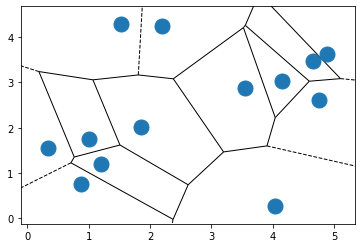

In [21]:
import sys
import scipy
import csv
import numpy as np 
import matplotlib.pyplot as plt
import math    

from math import atan, factorial as fac
from skimage import measure
from numpy import sin, cos, sinh, cosh,arcsin,arccos, pi, exp,abs, sqrt
from scipy.spatial import Voronoi, voronoi_plot_2d, distance
from matplotlib.collections import LineCollection

numpts = 3 
arr_size = 13 

frampts = np.random.uniform(low=0, high=5.0, size=(arr_size,2))


vor = Voronoi(frampts)

edges  = np.array(vor.ridge_vertices)
pts = vor.vertices 




fig = voronoi_plot_2d(vor, show_vertices=False , point_size=30)
'''
# line_width=2, line_alpha=0.6,

fig, axes = plt.subplots(figsize=(10,10)) #plt.figure(figsize=(10,10))
axes.fill(pt[:,0],pt[:,1], color ='k')

''' 




In [19]:
print(pts)

[[-0.43913679  1.75731121]
 [ 3.39549209  7.10546373]
 [ 0.54868282  3.80335002]
 [ 0.62645881  3.62308979]
 [ 2.86025058  0.53264844]
 [ 3.36350947 -0.31169078]
 [ 3.44259012  2.68656635]
 [ 1.64611949  3.28049518]
 [ 1.7837188   1.43984764]
 [ 1.18257205  1.81925968]
 [ 3.46112306  3.16616992]
 [ 3.26743331  3.77517385]
 [ 3.31816522  6.50215566]
 [ 3.03970648  5.18625528]
 [ 4.54908074  2.66903236]
 [ 4.48227892  2.1102699 ]
 [ 4.47883292  2.12617827]
 [22.35901827  1.48363967]
 [ 4.8329899   2.85970443]]


In [20]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage.morphology import binary_erosion
from scipy.spatial import Voronoi
from shapely.geometry import Point, Polygon
from skimage import draw
from sklearn.neighbors import KDTree

def get_circular_se(radius=2):

    N = (radius * 2) + 1
    se = np.zeros(shape=[N,N])
    for i in range(N):
        for j in range(N):
                se[i,j] = (i - N / 2)**2 + (j - N / 2)**2 <= radius**2
    se = np.array(se, dtype="uint8")
    return se

def polygonize_by_nearest_neighbor(pp):
    """Takes a set of xy coordinates pp Numpy array(n,2) and reorders the array to make
    a polygon using a nearest neighbor approach.

    """

    # start with first index
    pp_new = np.zeros_like(pp)
    pp_new[0] = pp[0]
    p_current_idx = 0

    tree = KDTree(pp)

    for i in range(len(pp) - 1):

        nearest_dist, nearest_idx = tree.query([pp[p_current_idx]], k=4)  # k1 = identity
        nearest_idx = nearest_idx[0]

        # finds next nearest point along the contour and adds it
        for min_idx in nearest_idx[1:]:  # skip the first point (will be zero for same pixel)
            if not pp[min_idx].tolist() in pp_new.tolist():  # make sure it's not already in the list
                pp_new[i + 1] = pp[min_idx]
                p_current_idx = min_idx
                break

    pp_new[-1] = pp[0]
    return pp_new


#generates a circular mask
side_len = 512
rad = 100
mask = np.zeros(shape=(side_len, side_len))
rr, cc = draw.circle(side_len/2, side_len/2, radius=rad, shape=mask.shape)
mask[rr, cc] = 1

#makes a polygon from the mask perimeter
se = get_circular_se(radius=1)
contour = mask - binary_erosion(mask, structure=se)
pixels_mask = np.array(np.where(contour==1)[::-1]).T
polygon = polygonize_by_nearest_neighbor(pixels_mask)
polygon = Polygon(polygon)

#generates random seeds
points_x = np.random.random_integers(0,side_len,250)
points_y = np.random.random_integers(0,side_len,250)
points = (np.vstack((points_x,points_y))).T

# returns a list of the centroids that are contained within the polygon
new_points = []
for point in points:
    if polygon.contains(Point(point)):
        new_points.append(point)

#performs voronoi tesselation
if len(points) > 3: #otherwise the tesselation won't work
    vor = Voronoi(new_points)
    regions, vertices = voronoi_finite_polygons_2d(vor)


FileNotFoundError: Could not find module 'C:\Users\AdminSi\Anaconda3\envs\ML3DCAD\Library\bin\geos_c.dll' (or one of its dependencies). Try using the full path with constructor syntax.

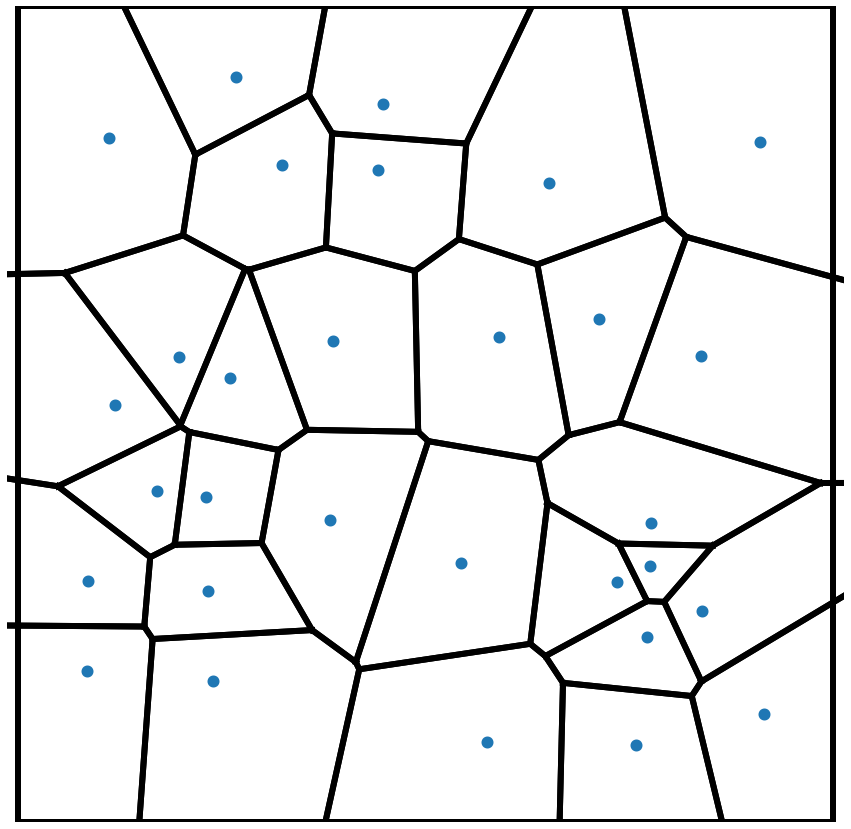

In [108]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi

def voronoi_finite_polygons_2d(vor, radius=None):

    if vor.points.shape[1] != 2:
        raise ValueError("Requires 2D input")

    new_regions = []
    new_vertices = vor.vertices.tolist()

    center = vor.points.mean(axis=0)
    if radius is None:
        radius = vor.points.ptp().max()*2

    # Construct a map containing all ridges for a given point
    all_ridges = {}
    for (p1, p2), (v1, v2) in zip(vor.ridge_points, vor.ridge_vertices):
        all_ridges.setdefault(p1, []).append((p2, v1, v2))
        all_ridges.setdefault(p2, []).append((p1, v1, v2))

    # Reconstruct infinite regions
    for p1, region in enumerate(vor.point_region):
        vertices = vor.regions[region]

        if all(v >= 0 for v in vertices):
            # finite region
            new_regions.append(vertices)
            continue

        # reconstruct a non-finite region
        ridges = all_ridges[p1]
        new_region = [v for v in vertices if v >= 0]

        for p2, v1, v2 in ridges:
            if v2 < 0:
                v1, v2 = v2, v1
            if v1 >= 0:
                # finite ridge: already in the region
                continue

            # Compute the missing endpoint of an infinite ridge

            t = vor.points[p2] - vor.points[p1] # tangent
            t /= np.linalg.norm(t)
            n = np.array([-t[1], t[0]])  # normal

            midpoint = vor.points[[p1, p2]].mean(axis=0)
            direction = np.sign(np.dot(midpoint - center, n)) * n
            far_point = vor.vertices[v2] + direction * radius

            new_region.append(len(new_vertices))
            new_vertices.append(far_point.tolist())

        # sort region counterclockwise
        vs = np.asarray([new_vertices[v] for v in new_region])
        c = vs.mean(axis=0)
        angles = np.arctan2(vs[:,1] - c[1], vs[:,0] - c[0])
        new_region = np.array(new_region)[np.argsort(angles)]

        # finish
        new_regions.append(new_region.tolist())

    return new_regions, np.asarray(new_vertices)

# make up data points
np.random.seed(100)
points = np.random.rand(30, 2)

# compute Voronoi tesselation
vor = Voronoi(points)

# plot
regions, vertices = voronoi_finite_polygons_2d(vor)

# colorize
for region in regions:
    polygon = vertices[region]
    #plt.fill(*zip(*polygon), alpha=0.4)
    
reg = np.array(np.array(regions))
num_reg = reg.shape[0]
fig = plt.figure(figsize=(15,15))
edges_all = [] 
for item in reg: 
    #print(item)
    for i in range(len(item)):
        vertx = np.array([vertices[item[i]],vertices[item[(i+1)%len(item)]]] )
        #print(vertices[item[i]])    
        plt.plot(vertx[:,0],vertx[:,1], "k",linewidth=6 )

plt.scatter(points[:,0], points[:,1],linewidth=6 )

#plt.plot(points[:,0], points[:,1], 'ko')

min_x = vor.min_bound[0] - 0.1
max_x = vor.max_bound[0] + 0.1
min_y = vor.min_bound[0] - 0.1
max_y = vor.max_bound[0] + 0.1


plt.plot([min_x,max_x,max_x,min_x,min_x],[min_y,min_y,max_y,max_y,min_y],"k",linewidth=6 )
plt.axis('equal')
plt.xlim(min_x,max_x)
plt.ylim(min_y,max_y )
plt.axis('off')
#plt.savefig('voro.png')
plt.show()

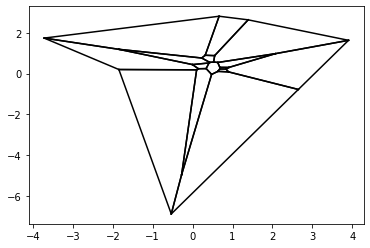

In [74]:
reg = np.array(np.array(regions))
num_reg = reg.shape[0]

edges_all = [] 
for item in reg: 
    #print(item)
    for i in range(len(item)):
        vertx = np.array([vertices[item[i]],vertices[item[(i+1)%len(item)]]] )
        #print(vertices[item[i]])    
        plt.plot(vertx[:,0],vertx[:,1], "k")

plt.show()
        